# Forward modelling with Marmousi velocity model

In this example we will load the Marmousi 1 Vp model, specify source and receiver locations, and then use Deepwave to perform forward modelling, propagating the sources through the model to generate synthetic receiver data.

First, we need to import the necessary packages:

In [32]:
import os
import sys

import deepwave
from deepwave import scalar
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import torch

sys.path.append("../")
sys.path.append(os.path.join(os.path.dirname(""), os.pardir))
import coherence_analysis.utils as f

We then choose which device we wish to run on, specify the size of the model, and load it:

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# ny = 2301
# nx = 751
ny = 2301
nx = 751
dx = 0.5

# v = 1500 * torch.ones(ny, nx)
# v[int(ny/2):] = 2000

marmousi_offset_left = 200
marmousi_offset_right = 0
ny = min(2301 - marmousi_offset_left - marmousi_offset_right, ny)

assert (
    marmousi_offset_left + marmousi_offset_right + ny <= 2301
), "Offsets exceed the model size."
assert (
    min(marmousi_offset_left, marmousi_offset_right) == 0
), "To stay true to offsets, one side must be unrestricted i.e set to 0."

v = torch.from_file("marmousi_vp.bin", size=(ny + marmousi_offset_left) * nx)
v = v[marmousi_offset_left * nx :].reshape(ny, nx).to(device)

Make a plot of the velocity model:

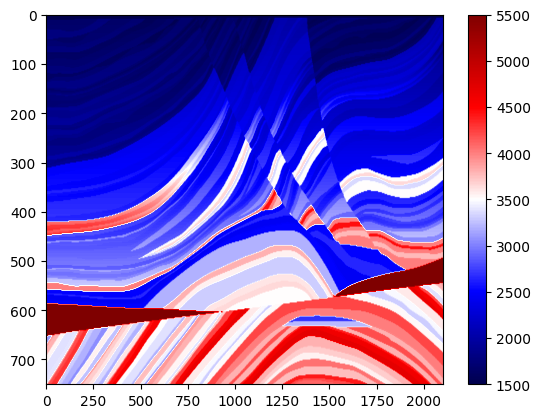

In [4]:
plt.imshow(v.cpu().numpy().T, cmap="seismic", aspect="auto")
plt.colorbar()

Next we will specify where we wish to place the sources and receivers, and what the source wavelets should be. Deepwave can propagate batches of shots simultaneously. This is purely to improve computational performance - they do not interact with each other and the results should be the same as if the shots were propagated individually. Shots propagated simultaneously are assumed to have the same number of sources and receivers, so we can provide their locations in Tensors with dimensions [shot, source, space], and [shot, receiver, space], respectively, and the source amplitudes in a Tensor with dimensions [shot, source, time]. Many applications only have one source per shot, so the source dimension will be of unit length, but Deepwave provides to option to have more:

In [5]:
n_shots = 1

n_sources_per_shot = 1
d_source = 20  # 20 * 4m = 80m
first_source = 10  # 10 * 4m = 40m
source_depth = 20  # 2 * 4m = 8m
# first_source = int(ny/2)
# source_depth = int(2*nx/3)

n_receivers_per_shot = 384
d_receiver = 6  # 6 * 4m = 24m
first_receiver = 0  # 0 * 4m = 0m
receiver_depth = 2  # 2 * 4m = 8m

n_receivers_per_shot = min(n_receivers_per_shot, int(nx / d_receiver))

freq = 10
nt = 750 * 3
dt = 0.004
peak_time = 20 / freq

# source_locations
source_locations = torch.zeros(
    n_shots, n_sources_per_shot, 2, dtype=torch.long, device=device
)
source_locations[..., 1] = source_depth
source_locations[:, 0, 0] = torch.arange(n_shots) * d_source + first_source

# receiver_locations
receiver_locations = torch.zeros(
    n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device
)
receiver_locations[..., 1] = receiver_depth
receiver_locations[:, :, 0] = (
    torch.arange(n_receivers_per_shot) * d_receiver + first_receiver
).repeat(n_shots, 1)

# source_amplitudes
source_amplitudes = (
    deepwave.wavelets.ricker(freq, nt, dt, peak_time)
    .repeat(n_shots, n_sources_per_shot, 1)
    .to(device)
)

Both spatial dimensions are treated equally in Deepwave. In this example we chose to orient our velocity model so that dimension 0 is horizontal and dimension 1 is vertical, and specified our source and receiver locations in a way that is consistent with that, but we could have transposed the model and used dimension 0 as depth if we wished.

That’s all the setup that we need for forward modelling, so we are now ready to call Deepwave. As we would like to ensure that the results are as accurate as possible, we will specify that we wish to use 8th order accurate spatial finite differences:

Text(0.5, 1.0, 'Ricker wavelet')

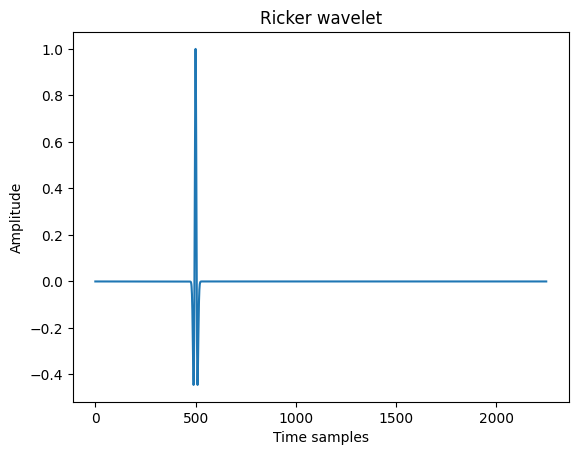

In [6]:
freq = 10
nt = 750 * 3
dt = 0.004
peak_time = 20 / freq

ricker_wavelet = deepwave.wavelets.ricker(freq, nt, dt, peak_time)
plt.plot(ricker_wavelet)
plt.xlabel("Time samples")
plt.ylabel("Amplitude")
plt.title("Ricker wavelet")

### Propagate wavefield to generate synthetic receiver data

In [7]:
out = scalar(
    v,
    dx,
    dt,
    source_amplitudes=source_amplitudes,
    source_locations=source_locations,
    receiver_locations=receiver_locations,
    accuracy=8,
    pml_freq=freq,
)

The *pml_freq* parameter is optional, but is recommended as it allows you to specify the dominant frequency to the PML, which helps to minimise edge reflections. You can see that the source and receiver Tensors that we provided were also optional. You can instead (or in addition) provide initial wavefields for Deepwave to propagate.

The number of time steps to propagate for (and thus the length of the output receiver data) is specified by the length of the source amplitude. If you are propagating without a source term, then you can instead specify it using the nt keyword parameter.

Finally, we will plot one common shot gather and one common receiver gather of the generated data, and then save the data to disk for use in later examples:

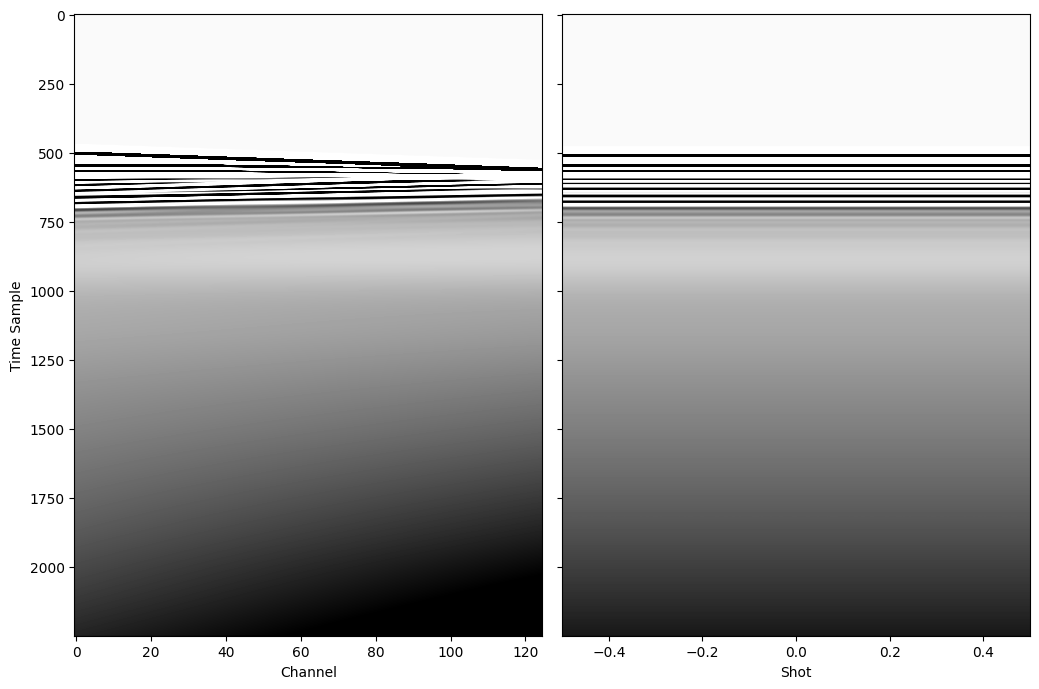

In [8]:
receiver_amplitudes = out[-1]
# shot_index = 57
# receiver_index = 192
shot_index = 0
receiver_index = 19
vmin, vmax = torch.quantile(
    receiver_amplitudes[0], torch.tensor([0.05, 0.95]).to(device)
)
_, ax = plt.subplots(1, 2, figsize=(10.5, 7), sharey=True)
ax[0].imshow(
    receiver_amplitudes[shot_index].cpu().T,
    aspect="auto",
    cmap="gray",
    vmin=vmin,
    vmax=vmax,
)
ax[1].imshow(
    receiver_amplitudes[:, receiver_index].cpu().T,
    aspect="auto",
    cmap="gray",
    vmin=vmin,
    vmax=vmax,
)
ax[0].set_xlabel("Channel")
ax[0].set_ylabel("Time Sample")
ax[1].set_xlabel("Shot")
plt.tight_layout()

# receiver_amplitudes.cpu().numpy().tofile('marmousi_data.bin')

There is a side reflection that shows up pretty strongly in the plot of the receiver gather. Adjusting the color scale shows that this side reflection is actually quite weak, and the main reflection is much stronger.

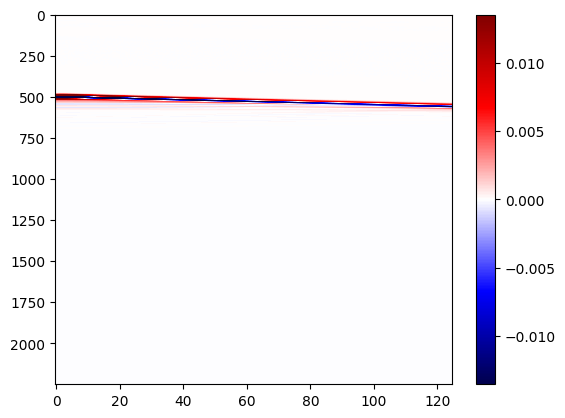

In [9]:
vmin, vmax = torch.quantile(
    receiver_amplitudes[0], torch.tensor([0.1, 0.999]).to(device)
)
plt.imshow(
    receiver_amplitudes.cpu()[0].T,
    aspect="auto",
    cmap="seismic",
    vmin=-vmax,
    vmax=vmax,
)
plt.colorbar()

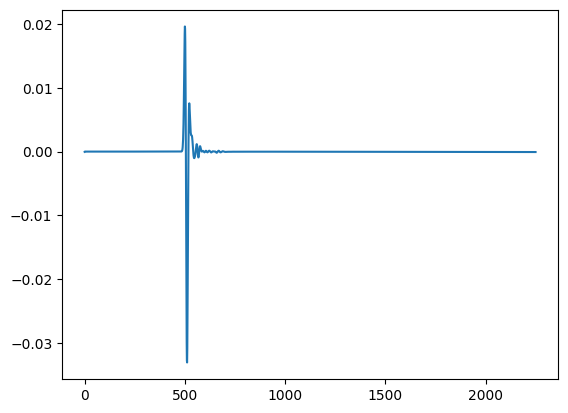

In [10]:
plt.plot(receiver_amplitudes.cpu()[0, 19])

We did not need to use them in this case, but if the output receiver amplitudes contain undesirable wraparound artifacts (where high amplitudes at the end of a trace cause artifacts at the beginning of the trace) then the Deepwave propagator options freq_taper_frac and time_pad_frac should be helpful. 

Add some noise to the data. This does two things in this example: 
- It makes the data look more realistic and assess the robustness of coherence to noise.
- It avoids the issue of the data being too perfect and the coherence being 1.0 in frequency range of the source and "weird" elsewhere.

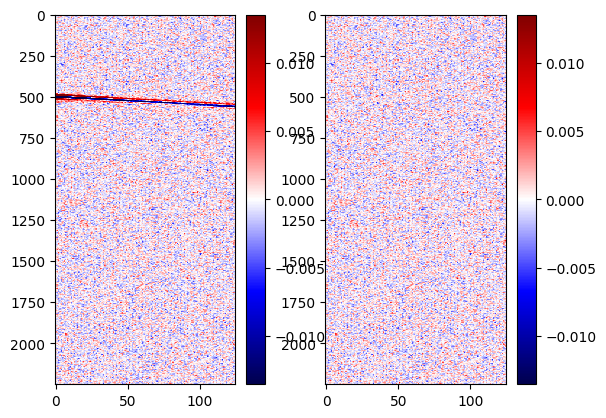

In [11]:
coherence_data = receiver_amplitudes[0].cpu().numpy()
nr, nc = coherence_data.shape
noise = np.random.normal(scale=1, size=(nr, nc))
# normalize noise
noise = noise / np.linalg.norm(noise)
noise = noise * np.max(np.abs(coherence_data)) * 40
coherence_data = coherence_data + noise
# coherence_data.shape
vmin, vmax = torch.quantile(
    receiver_amplitudes[0], torch.tensor([0.1, 0.999]).to(device)
)
plt.subplot(1, 2, 1)
plt.imshow(
    coherence_data.T, aspect="auto", cmap="seismic", vmin=-vmax, vmax=vmax
)
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(noise.T, aspect="auto", cmap="seismic", vmin=-vmax, vmax=vmax)
plt.colorbar()

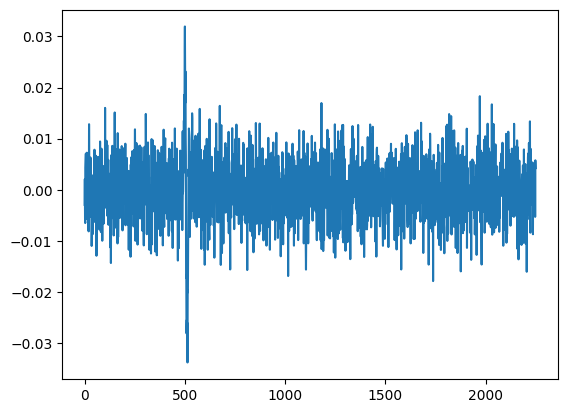

In [12]:
plt.plot(coherence_data[19])

In [13]:
win_len = 1
overlap = 0
samples_per_sec = 1 / dt

t0 = time.time()
norm_win_spectra, frequencies = f.normalised_windowed_spectra(
    coherence_data, win_len, overlap, sample_interval=1 / samples_per_sec
)
t1 = time.time()
common_time = t1 - t0

welch_coherence_mat = np.matmul(
    norm_win_spectra, np.conjugate(norm_win_spectra.transpose(0, 2, 1))
)
coherence = np.absolute(welch_coherence_mat) ** 2

norm_win_spectra_noise, frequencies = f.normalised_windowed_spectra(
    noise, win_len, overlap, sample_interval=1 / samples_per_sec
)
welch_coherence_mat_noise = np.matmul(
    norm_win_spectra_noise,
    np.conjugate(norm_win_spectra_noise.transpose(0, 2, 1)),
)
coherence_noise = np.absolute(welch_coherence_mat_noise) ** 2

In [14]:
t0 = time.time()
preprocessed_data = f.covariance_preprocessing(coherence_data, sample_interval=1/samples_per_sec)
win_spectra, frequencies = f.windowed_spectra(
    preprocessed_data,
    win_len,
    overlap,
    freq=None,
    sample_interval=1/samples_per_sec,
)
win_spectra = win_spectra.transpose(2, 1, 0)

t1 = time.time()
covariance_time = t1 - t0

norm_win_spectra_noise, frequencies = f.normalised_windowed_spectra(
    noise, win_len, overlap, sample_interval=1 / samples_per_sec
)

preprocessed_data_noise = f.covariance_preprocessing(noise, sample_interval=1/samples_per_sec)
win_spectra_noise, frequencies = f.windowed_spectra(
    preprocessed_data_noise,
    win_len,
    overlap,
    freq=None,
    sample_interval=1/samples_per_sec,
)
win_spectra_noise = win_spectra_noise.transpose(2, 1, 0)



num_frames = win_spectra_noise.shape[0]
eig_ratios_covariance = np.empty(num_frames)
eig_ratios_covariance_noise = np.empty(num_frames)

for d in range(num_frames):
    # U, S, Vh = np.linalg.svd(win_spectra_noise[d])
    S = np.linalg.svd(
            win_spectra[d],
            compute_uv=False,
            hermitian=False,
        )
    svd_approx2 = S**2
    # svd_approx2 = np.sort(S)[::-1]**2
    eig_ratios_covariance[d] = np.max(svd_approx2) / np.sum(svd_approx2)
for d in range(num_frames):
    # U, S, Vh = np.linalg.svd(win_spectra_noise[d])
    S = np.linalg.svd(
            win_spectra_noise[d],
            compute_uv=False,
            hermitian=False,
        )
    svd_approx2 = S**2
    # svd_approx2 = np.sort(S)[::-1]**2
    eig_ratios_covariance_noise[d] = np.max(svd_approx2) / np.sum(svd_approx2)


In [15]:
noise_factors = [0.1, 0.5, 1, 2, 5, 10, 20, 50, 100]
num_frames = win_spectra_noise.shape[0]
eig_ratios_covariance = np.empty((len(noise_factors), num_frames))
eig_ratios_covariance_noise = np.empty((len(noise_factors), num_frames))

eig_ratios_coherence = np.empty((len(noise_factors), num_frames))
eig_ratios_coherence_noise = np.empty((len(noise_factors), num_frames))

eig_ratios_coherence_qr = np.empty((len(noise_factors), num_frames))
eig_ratios_coherence_noise_qr = np.empty((len(noise_factors), num_frames))

nf = 0
data = receiver_amplitudes[0].cpu().numpy()
nr, nc = data.shape
noise = np.random.normal(scale=1, size=(nr, nc))
# normalize noise
noise = noise / np.linalg.norm(noise)

for noise_factor in noise_factors:

    coherence_data = data + noise * np.max(np.abs(coherence_data)) * noise_factor

    preprocessed_data = f.covariance_preprocessing(coherence_data, sample_interval=1/samples_per_sec)
    win_spectra, frequencies = f.windowed_spectra(
        preprocessed_data,
        win_len,
        overlap,
        freq=None,
        sample_interval=1/samples_per_sec,
    )
    win_spectra = win_spectra.transpose(2, 1, 0)

    preprocessed_data_noise = f.covariance_preprocessing(noise, sample_interval=1/samples_per_sec)
    win_spectra_noise, frequencies = f.windowed_spectra(
        preprocessed_data_noise,
        win_len,
        overlap,
        freq=None,
        sample_interval=1/samples_per_sec,
    )
    win_spectra_noise = win_spectra_noise.transpose(2, 1, 0)

    norm_win_spectra, frequencies = f.normalised_windowed_spectra(
        coherence_data, win_len, overlap, sample_interval=1 / samples_per_sec
    )

    norm_win_spectra_noise, frequencies = f.normalised_windowed_spectra(
        noise, win_len, overlap, sample_interval=1 / samples_per_sec
    )

    for d in range(num_frames):
    # U, S, Vh = np.linalg.svd(win_spectra_noise[d])
        S = np.linalg.svd(
                win_spectra[d],
                compute_uv=False,
                hermitian=False,
            )
        svd_approx2 = S**2
        # svd_approx2 = np.sort(S)[::-1]**2
        eig_ratios_covariance[nf, d] = np.max(svd_approx2) / np.sum(svd_approx2)

        # U, S, Vh = np.linalg.svd(win_spectra_noise[d])
        S = np.linalg.svd(
                win_spectra_noise[d],
                compute_uv=False,
                hermitian=False,
            )
        svd_approx2 = S**2
        # svd_approx2 = np.sort(S)[::-1]**2
        eig_ratios_covariance_noise[nf, d] = np.max(svd_approx2) / np.sum(svd_approx2)


    # U, S, Vh = np.linalg.svd(win_spectra_noise[d])
        S = np.linalg.svd(
                norm_win_spectra[d],
                compute_uv=False,
                hermitian=False,
            )
        svd_approx2 = S**2
        # svd_approx2 = np.sort(S)[::-1]**2
        eig_ratios_coherence[nf, d] = np.max(svd_approx2) / np.sum(svd_approx2)

        # U, S, Vh = np.linalg.svd(win_spectra_noise[d])
        S = np.linalg.svd(
                norm_win_spectra_noise[d],
                compute_uv=False,
                hermitian=False,
            )
        svd_approx2 = S**2
        # svd_approx2 = np.sort(S)[::-1]**2
        eig_ratios_coherence_noise[nf, d] = np.max(svd_approx2) / np.sum(svd_approx2)


        Q, R = np.linalg.qr(norm_win_spectra[d])
        RRH = R @ (np.matrix(R).H)
        # diag is of sqrt(RR^*)
        qr_approx2 = np.power(np.diag(RRH), 0.5)
        eig_ratios_coherence_qr[nf, d] = np.max(qr_approx2) / np.sum(qr_approx2)

        Q, R = np.linalg.qr(norm_win_spectra_noise[d])
        RRH = R @ (np.matrix(R).H)
        # diag is of sqrt(RR^*)
        qr_approx2 = np.power(np.diag(RRH), 0.5)
        eig_ratios_coherence_noise_qr[nf, d] = np.max(qr_approx2) / np.sum(qr_approx2)

    nf += 1

C:\Users\issah\AppData\Local\Temp\ipykernel_1312\3913763526.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  eig_ratios_coherence_qr[nf, d] = np.max(qr_approx2) / np.sum(qr_approx2)
C:\Users\issah\AppData\Local\Temp\ipykernel_1312\3913763526.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  eig_ratios_coherence_noise_qr[nf, d] = np.max(qr_approx2) / np.sum(qr_approx2)


Text(0.5, 1.0, 'Covariance eigenvalue ratio')

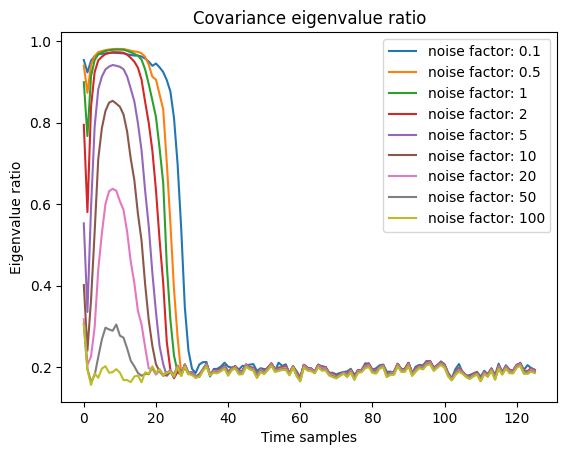

In [16]:
for nf in range(len(noise_factors)):
    plt.plot(eig_ratios_covariance[nf], label=f"noise factor: {noise_factors[nf]}")
plt.legend()
plt.xlabel("Time samples")
plt.ylabel("Eigenvalue ratio")
plt.title("Covariance eigenvalue ratio")

Text(0.5, 1.0, 'Coherence eigenvalue ratio')

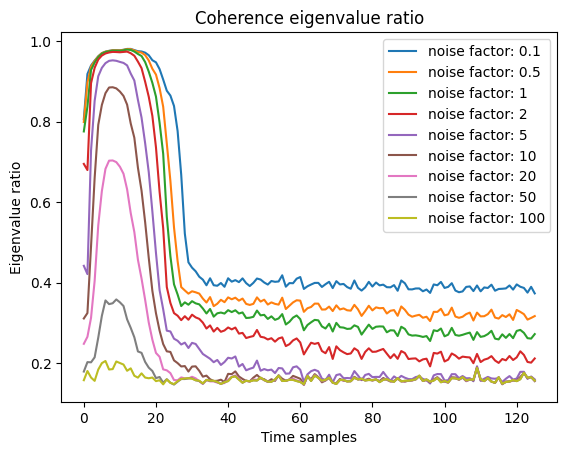

In [17]:
for nf in range(len(noise_factors)):
    plt.plot(eig_ratios_coherence[nf], label=f"noise factor: {noise_factors[nf]}")
plt.legend()
plt.xlabel("Time samples")
plt.ylabel("Eigenvalue ratio")
plt.title("Coherence eigenvalue ratio")

Text(0.5, 1.0, 'Coherence eigenvalue ratio')

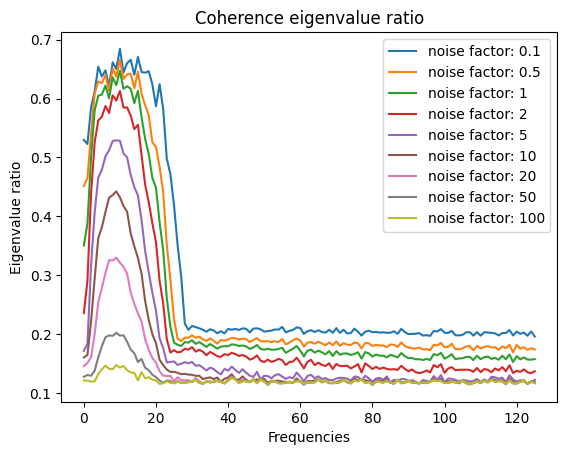

In [18]:
for nf in range(len(noise_factors)):
    plt.plot(eig_ratios_coherence_qr[nf], label=f"noise factor: {noise_factors[nf]}")
plt.legend()
plt.xlabel("Frequencies")
plt.ylabel("Eigenvalue ratio")
plt.title("Coherence eigenvalue ratio")

Text(0, 0.5, 'Eigenvalue ratio')

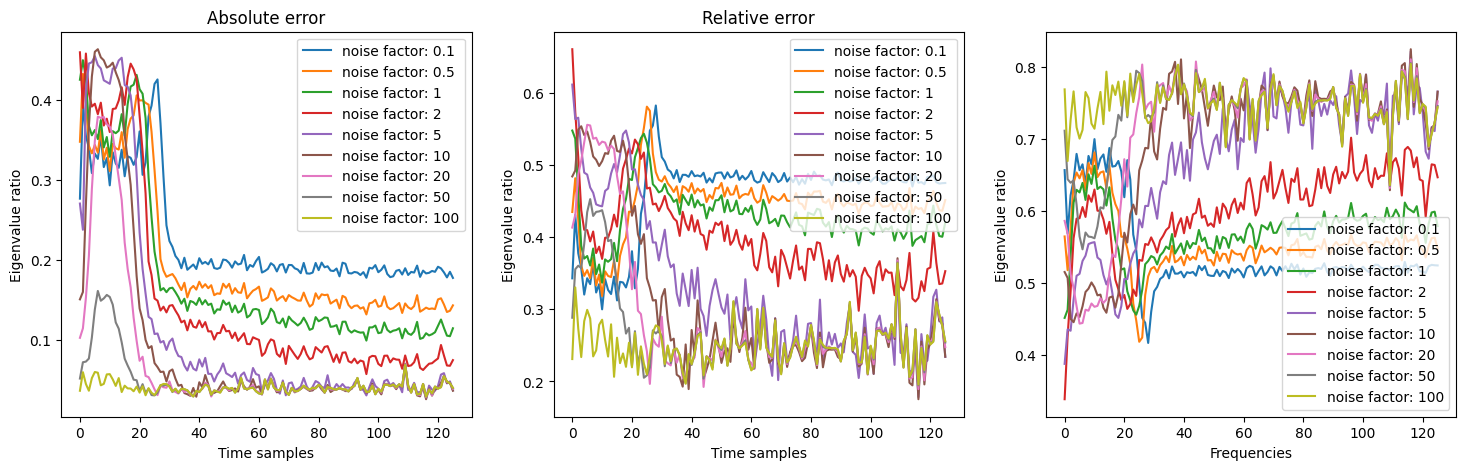

In [39]:
absolute_errors = np.abs(eig_ratios_coherence - eig_ratios_coherence_qr)
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
for nf in range(len(noise_factors)):
    plt.plot(absolute_errors[nf], label=f"noise factor: {noise_factors[nf]}")
plt.legend()
plt.xlabel("Time samples")
plt.ylabel("Eigenvalue ratio")
plt.title("Absolute error")
plt.subplot(1, 3, 2)
relative_errors = absolute_errors / eig_ratios_coherence
for nf in range(len(noise_factors)):
    plt.plot(relative_errors[nf], label=f"noise factor: {noise_factors[nf]}")
plt.legend()
plt.xlabel("Time samples")
plt.ylabel("Eigenvalue ratio")
plt.title("Relative error")
plt.subplot(1, 3, 3)
for nf in range(len(noise_factors)):
    # sns.histplot((eig_ratios_coherence_qr[nf][1:])/eig_ratios_coherence[nf][1:], kde=True, fill=True, alpha=0.5, bins=10)
    plt.plot(eig_ratios_coherence_qr[nf] / eig_ratios_coherence[nf], label=f"noise factor: {noise_factors[nf]}")
plt.legend()
plt.xlabel("Frequencies")
plt.ylabel("Eigenvalue ratio")

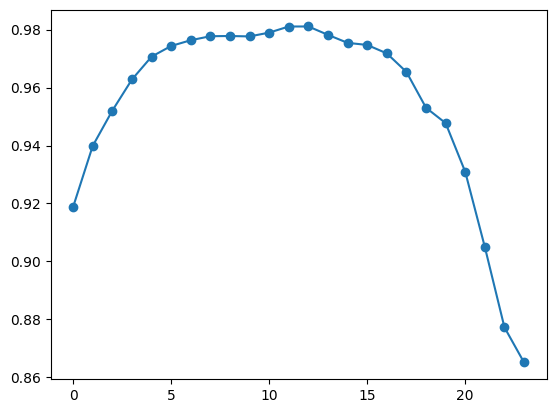

In [27]:
plt.plot(eig_ratios_coherence[0, 1:25], "-o")

Text(0, 0.5, 'Count')

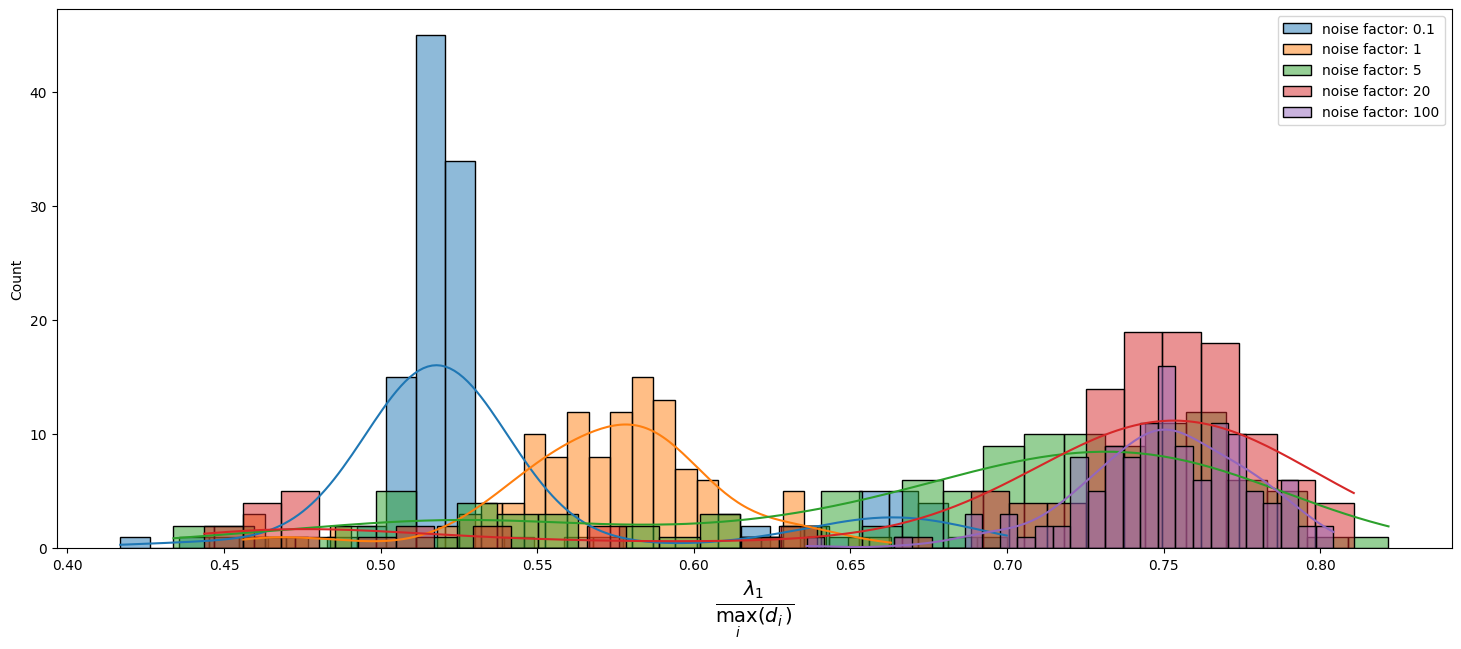

In [42]:
plt.figure(figsize=(18, 7))
for nf in range(0, len(noise_factors), 2):
    sns.histplot((eig_ratios_coherence_qr[nf][1:])/eig_ratios_coherence[nf][1:], kde=True, fill=True, alpha=0.5, label=f"noise factor: {noise_factors[nf]}", bins=30)
    # plt.plot(eig_ratios_coherence_qr[nf] / eig_ratios_coherence[nf], label=f"noise factor: {noise_factors[nf]}")
plt.legend()
plt.xlabel(r"$\frac{\lambda_1}{\max_i (d_i)}$", fontsize=20)
# plt.xlabel("Frequencies")
plt.ylabel("Count")

Text(0, 0.5, 'Eigenvalue ratio')

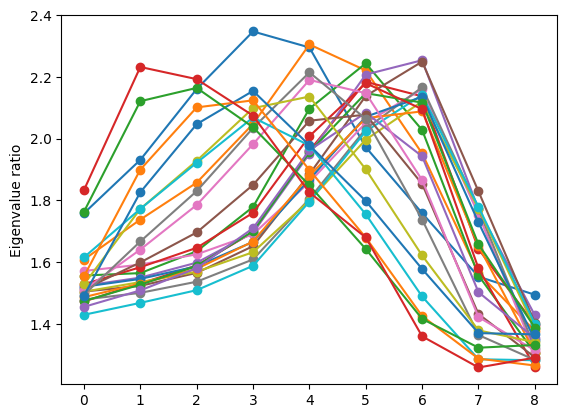

In [31]:
eig_qr_ratios = eig_ratios_coherence / eig_ratios_coherence_qr
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
for i in range(1, 25): # len(frequencies)):
    plt.plot(eig_qr_ratios[:, i], label=f"Frequency: {frequencies[i]}", marker="o")
# plt.legend()
plt.ylabel("Eigenvalue ratio")
# plt.title("Absolute error")
# plt.subplot(1, 2, 2)
# relative_errors = absolute_errors / eig_ratios_coherence
# for i in range(len(noise_factors)):
#     plt.plot(relative_errors[nf], label=f"Frequency: {frequencies[i]}")
# plt.legend()
# plt.xlabel("Time samples")
# plt.ylabel("Eigenvalue ratio")
# plt.title("Relative error")